# 基于 Seq2Seq 模型的机器翻译实践

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from datasets import load_dataset

# Step1: 加载数据集，并进行数据预处理

## 1.1 加载本地数据集

使用 huggingface 的 datasets 库来加载一个 huggingface 上的数据集（本数据集已经下载到本地）。并划分训练集与数据集。

使用的是HuggingFace dataset 中的一个中英翻译的一个数据集：[Garsa3112/ChineseEnglishTranslationDataset](https://huggingface.co/datasets/Garsa3112/ChineseEnglishTranslationDataset)

In [2]:
translation_data = load_dataset(
    "arrow",
    data_files={
        "train": "/data/datasets/Garsa3112/ChineseEnglishTranslationDataset/train.arrow"
    },
    split="train",
)

num_samples = len(translation_data)

# 划分训练和测试数据集，测试集占20%
train_test_data = translation_data.train_test_split(test_size=0.02)

# 将数据集的随机10条记录转换为DataFrame并展示
sample_idx = np.random.randint(0, num_samples, 10)
sample_df = pd.DataFrame(translation_data.select(sample_idx))
sample_df.head()

,en,zh
0,"While working on the Netscape browser, Montull...","在开发Netscape浏览器的时候,蒙特利建立了Fishcam ,它是最早的直播网站之一,F..."
1,He also studied volcanism and seismic phenomen...,"他还研究地球上的火山作用和地震现象,有时甚至冒着生命危险。"
2,During an interview with BBC News reporter Orl...,"在英国广播公司新闻记者Orla Guerin2012年8月的专访中,萨利赫·穆斯林否认他与库..."
3,"At that point, we got the fear.","那时候,我们就感觉害怕了。"
4,"From an algebraic viewpoint, this means that o...","从泛代数的角度,这意味着人们希望为所考虑的结构找到适当的同态概念。"


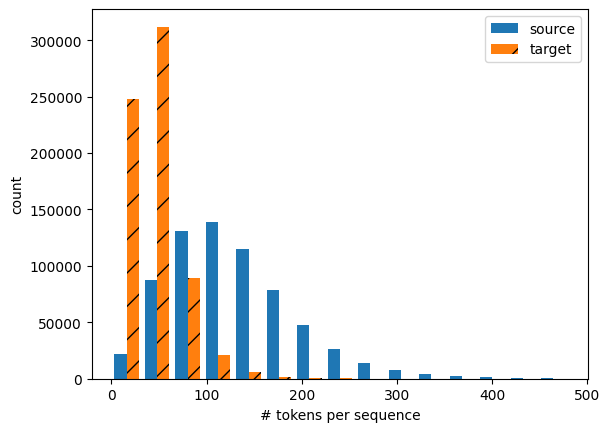

In [3]:
text_length = [(len(sample["en"]), len(sample["zh"])) for sample in translation_data]
src_seq_length, tgt_seq_length = zip(*text_length)

bins = np.arange(0, 512, 32)
_, _, patches = plt.hist(
    [src_seq_length, tgt_seq_length],
    bins=bins,
)
plt.xlabel("# tokens per sequence")
plt.ylabel("count")
for patch in patches[1].patches:
    patch.set_hatch("/")
plt.legend(["source", "target"])

plt.show()

## 1.2 创建分词器，并创建 Dataloader

通过自定义的 collate function 来对翻译的源文本与目标文本分别进行分词并转换为 token ids

In [4]:
from functools import partial


def collate_fn(batch_example, tokenizer, src_max_length, tgt_max_length):
    src_texts = []
    tgt_texts = []
    for example in batch_example:
        src_texts.append(example["en"])
        tgt_texts.append(tokenizer.bos_token + example["zh"] + tokenizer.eos_token)
    src_tokenized = tokenizer(
        src_texts,
        padding="longest",
        max_length=src_max_length,
        truncation=True,
        return_tensors="pt",
        add_special_tokens=False,
    )
    tgt_tokenized = tokenizer(
        tgt_texts,
        padding="longest",
        max_length=tgt_max_length,
        truncation=True,
        return_tensors="pt",
        add_special_tokens=False,
    )
    labels = tgt_tokenized.input_ids[:, 1:]
    labels = torch.where(labels != tokenizer.pad_token_id, labels, -100)

    return {
        "src_input_ids": src_tokenized.input_ids,
        "src_attention_mask": src_tokenized.attention_mask,
        "tgt_input_ids": tgt_tokenized.input_ids[:, :-1],
        "tgt_attention_mask": tgt_tokenized.attention_mask[:, :-1],
        "labels": labels,
    }


tokenizer = AutoTokenizer.from_pretrained(
    "hfl/chinese-macbert-base",
    clean_up_tokenization_spaces=False,
)
tokenizer.add_special_tokens(
    {
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }
)

batch_size = 32
src_max_length = 384
tgt_max_length = 256

train_dataloader = DataLoader(
    train_test_data["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=partial(
        collate_fn,
        tokenizer=tokenizer,
        src_max_length=src_max_length,
        tgt_max_length=tgt_max_length,
    ),
)

validation_dataloader = DataLoader(
    train_test_data["test"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=partial(
        collate_fn,
        tokenizer=tokenizer,
        src_max_length=src_max_length,
        tgt_max_length=tgt_max_length,
    ),
)

# Step2. 创建模型

In [5]:
def create_positional_embedding(max_len=256, embed_dim=512):
    """
    生成位置嵌入矩阵，用于为输入序列添加位置信息。

    参数:
    - max_len: 序列的最大长度
    - embed_dim: 嵌入向量的维度

    返回:
    - position_embeddings: 位置嵌入矩阵
    """
    position_indices = torch.arange(max_len)[:, None]
    div_term = torch.pow(10000, torch.arange(0, embed_dim, 2) / embed_dim)[None, :]
    position_embeddings = torch.zeros(max_len, embed_dim)
    position_embeddings[:, 0::2] = torch.sin(position_indices / div_term)
    position_embeddings[:, 1::2] = torch.cos(position_indices / div_term)

    return position_embeddings


def create_causal_mask(seq_len):
    """
    生成自回归掩码，用于避免在解码过程中看到未来的时间步。

    参数:
    - seq_len: 序列的长度

    返回:
    - causal_mask: 自回归掩码
    """
    return torch.triu(torch.ones(seq_len, seq_len), diagonal=1) == 1


class TransformerModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_seq_len,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p=0.1,
        device=None,
    ):
        """
        初始化Transformer模型，用于序列到序列的翻译任务。

        参数:
        - vocab_size: 词汇表大小
        - max_seq_len: 最大序列长度
        - d_model: 嵌入维度
        - nhead: 多头注意力机制的头数
        - num_encoder_layers: 编码器层数
        - num_decoder_layers: 解码器层数
        - dim_feedforward: 前馈网络的维度
        - device: 运行设备
        """
        super().__init__()

        # 词嵌入层
        self.token_embedding = nn.Embedding(vocab_size, d_model, device=device)

        # 位置嵌入矩阵
        self.positional_embedding = create_positional_embedding(
            max_seq_len, d_model
        ).to(device=device)

        self.dropout = nn.Dropout(p=dropout_p)

        # 编码器层和编码器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model,
            nhead,
            dim_feedforward,
            dropout=dropout_p,
            batch_first=True,
            norm_first=True,
            device=device,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_encoder_layers, enable_nested_tensor=False
        )

        # 解码器层和解码器
        decoder_layer = nn.TransformerDecoderLayer(
            d_model,
            nhead,
            dim_feedforward,
            dropout=dropout_p,
            batch_first=True,
            norm_first=True,
            device=device,
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)

        self.norm = nn.LayerNorm((d_model,), device=device)

        # 线性投影层，用于生成词汇表中的概率分布
        self.output_projection = nn.Linear(
            d_model, vocab_size, bias=False, device=device
        )

    def forward(self, src, tgt, src_attention_mask, tgt_attention_mask):
        """
        执行前向传播，计算模型输出。

        参数:
        - src: 源序列
        - tgt: 目标序列
        - src_attention_mask: 源序列的掩码
        - tgt_attention_mask: 目标序列的掩码

        返回:
        - output_logits: 预测的词汇分布
        """
        src_embed = self.token_embedding(src)
        batch_size, src_len = src.shape

        # 为源序列添加位置嵌入
        src_positions = torch.arange(0, src_len)[None, :].repeat(batch_size, 1)
        src_embed += self.positional_embedding[src_positions]

        # Dropout(0.1)
        src_embed = self.dropout(src_embed)

        # 源序列的掩码
        src_key_padding_mask = src_attention_mask == 0
        memory = self.encoder(src_embed, src_key_padding_mask=src_key_padding_mask)

        # 生成目标序列的嵌入
        tgt_len = tgt.size(1)
        tgt_embed = self.token_embedding(tgt)
        tgt_positions = torch.arange(0, tgt_len)[None, :].repeat(batch_size, 1)
        tgt_embed += self.positional_embedding[tgt_positions]

        tgt_key_padding_mask = tgt_attention_mask == 0
        causal_mask = create_causal_mask(tgt_len).to(device=tgt.device)

        # 解码器的输出
        decoder_output = self.decoder(
            tgt_embed,
            memory,
            memory_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_is_causal=True,
            tgt_mask=causal_mask,
        )

        # 通过线性层得到词汇分布
        output_logits = self.output_projection(self.norm(decoder_output))

        return output_logits

    @torch.inference_mode
    def predict(self, src_text, tokenizer, device, max_tokens=256):
        src_input_ids = tokenizer(src_text, return_tensors="pt").input_ids[0]
        src_input_ids = src_input_ids.to(device=device)
        src_len = src_input_ids.size(0)
        src_embed = self.token_embedding(src_input_ids)
        # 为源序列添加位置嵌入
        src_positions = torch.arange(0, src_len)
        src_embed += self.positional_embedding[src_positions]
        memory = self.encoder(src_embed)

        tgt_input_ids = torch.tensor(
            [tokenizer.bos_token_id], device=src_input_ids.device
        )

        for _ in range(max_tokens):
            tgt_len = tgt_input_ids.size(0)
            tgt_embed = self.token_embedding(tgt_input_ids)
            tgt_positions = torch.arange(0, tgt_len)
            tgt_embed += self.positional_embedding[tgt_positions]

            causal_mask = create_causal_mask(tgt_len).to(device=tgt_input_ids.device)

            # 解码器的输出
            decoder_output = self.decoder(
                tgt_embed,
                memory,
                memory_key_padding_mask=None,
                tgt_key_padding_mask=None,
                tgt_is_causal=True,
                tgt_mask=causal_mask,
            )

            # 通过线性层得到词汇分布
            output_logits = self.output_projection(self.norm(decoder_output))
            next_token_id = torch.argmax(output_logits[-1])[None]
            if next_token_id.item() == tokenizer.eos_token_id:
                break
            tgt_input_ids = torch.concat([tgt_input_ids, next_token_id])
        return tokenizer.decode(tgt_input_ids[1:], clean_up_tokenization_spaces=False)

In [6]:
d_model = 512
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 3
num_decoder_layers = 3
dropout_p = 0.1
device = torch.device("cuda", 0)
vocab_size = len(tokenizer)

model = TransformerModel(
    vocab_size,
    max(src_max_length, tgt_max_length),
    d_model,
    nhead,
    num_encoder_layers,
    num_decoder_layers,
    dim_feedforward,
    dropout_p=dropout_p,
    device=device,
)

# Step3 模型训练

## 3.1 模型评估函数

In [7]:
@torch.inference_mode()
def evaluate_model(model, dataloader, criterion, device):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # 关闭梯度计算
        for batch in dataloader:
            # 获取输入和目标数据
            src_input = batch["src_input_ids"].to(device)
            src_mask = batch["src_attention_mask"].to(device)
            tgt_input = batch["tgt_input_ids"].to(device)
            tgt_mask = batch["tgt_attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # 前向传播
            logits = model(src_input, tgt_input, src_mask, tgt_mask).transpose(1, 2)

            # 计算损失
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # 计算准确率
            predicted_labels = torch.argmax(logits, dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


@torch.inference_mode()
def test_samples(model, tokenizer, device):
    model.eval()
    tests_src = [
        "Welcome to school. Today is the first day of the new term.",
        "What methods can be used to improve English translation ability?",
        "I like the newly - released iPhone.",
        "Constantly practicing through code is a good way to learn deep learning.",
    ]
    for test in tests_src:
        tgt_text = model.predict(test, tokenizer, device)
        print(f"[SRC]: {test} \n[TGT]: {tgt_text}")

## 3.2 模型训练

In [8]:
import math


class WarmupCosineAnnealingLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, eta_min=0, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.eta_min = eta_min
        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Warmup阶段，线性增加
            return [
                base_lr * (self.last_epoch + 1) / self.warmup_epochs
                for base_lr in self.base_lrs
            ]
        else:
            # 进入cosine annealing阶段
            cos_inner = (self.last_epoch - self.warmup_epochs) / (
                self.max_epochs - self.warmup_epochs
            )
            return [
                self.eta_min
                + (base_lr - self.eta_min) * (1 + math.cos(math.pi * cos_inner)) / 2
                for base_lr in self.base_lrs
            ]

In [10]:
import logging

# 设置日志记录器
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")


# 训练参数
num_epochs = 5
n_steps = 0
steps_per_epoch = len(train_dataloader)
total_steps = num_epochs * steps_per_epoch
warmup_steps = total_steps * 0.05
log_interval = 200
eval_interval = 2000
grad_clip_value = 1.0  # 梯度裁剪阈值

# 优化器和调度器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = WarmupCosineAnnealingLR(
    optimizer, warmup_epochs=warmup_steps, max_epochs=total_steps, eta_min=1e-6
)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    for batch in train_dataloader:
        # 将输入和目标数据迁移到设备
        src = batch["src_input_ids"].to(device)
        src_attention_mask = batch["src_attention_mask"].to(device)
        tgt = batch["tgt_input_ids"].to(device)
        tgt_attention_mask = batch["tgt_attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # 向前传播
        logits = model(src, tgt, src_attention_mask, tgt_attention_mask).transpose(1, 2)

        # 计算损失
        loss = criterion(logits, labels)

        # 反向传播和梯度更新
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)  # 梯度裁剪
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        n_steps += 1

        if n_steps % log_interval == 0:
            logging.info(
                f"Epoch: {epoch + 1}/{num_epochs}, Step: {n_steps}, Loss: {loss.item():.4f}"
            )
        if n_steps % eval_interval == 0:
            test_samples(model, tokenizer, device)
            val_loss, val_accuracy = evaluate_model(
                model, validation_dataloader, criterion, device
            )
            logging.info(
                f"Validation - Epoch: {epoch + 1}, Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}"
            )

KeyboardInterrupt: 